## Description

In this notebook I am building a model with ExtraTreesClassifier, tuning it with GridSearchCV.

After that - I am using validation set to analyse the quality of model prediction and trying to remove some features to improve it


### Import DATA

In [1]:
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import multiprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
import joblib

C:\Users\sami_\AppData\Local\Temp\ipykernel_18220\3830478048.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
screenshots = pd.read_csv("./images/screenshots/screenshots.csv")

screenshots_ph = pd.read_csv("./images/screenshots_ph/screenshots_ph.csv")

receipts = pd.read_csv("./images/receipts/receipts.csv")

regulars = pd.read_csv("./images/regular/regular.csv")

not_good = pd.read_csv("./images/not_good/not_good.csv")

superb = pd.read_csv("./images/superb/superb.csv")

docs = pd.read_csv("./images/docs/docs.csv")

test = pd.read_csv("./images/test/test.csv")


### Labeling and spliting

In [4]:
# from_labels = ["docs", "not_good", "receipts", "regular", "screenshots", "screenshots_ph", "superb", "test"]

label = "receipts"

regulars[label] = 1
not_good[label] = 0
superb[label] = 1
screenshots[label] = 0
docs[label] = 0
screenshots_ph[label] = 0
receipts[label] = 1


whole_docs = pd.concat([regulars, not_good, superb, screenshots, docs, receipts, screenshots_ph], ignore_index=True)

In [5]:
whole_docs = whole_docs.drop(columns=["filename"])

In [6]:
y = whole_docs.pop(label)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(whole_docs, y, test_size=0.15, random_state=42)

## Running on 4 Classifiers

### ExtraTree simple

In [8]:
import classifiers_3 as c3

In [9]:
search_scr = c3.extratrees_model(X_train, y_train, c3.param_et)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Time taken to train the model: 7 minutes and 0.44 seconds
Best parameters: {'extratreesclassifier__min_samples_leaf': 1, 'extratreesclassifier__min_samples_split': 4, 'extratreesclassifier__n_estimators': 200}
Best score: 0.9074584050487665


### CatBoost

In [10]:
search_cb = c3.catboost_model(X_train, y_train, c3.param_cb)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Time taken to train the model: 10 minutes and 56.58 seconds
Best parameters: {'catboostclassifier__depth': 6, 'catboostclassifier__iterations': 350, 'catboostclassifier__l2_leaf_reg': 1e-20}
Best score: 0.9111302352266207


### LGBMClassifier

In [11]:
param_lgbm = {
        'n_estimators': range(100, 400, 50), 
        'num_leaves': range(20, 40, 5), 
        'min_child_samples': range(1, 20, 2)
}

search_lgbm = c3.lgbm_model(X_train, y_train, c3.param_lgbm)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[LightGBM] [Info] Number of positive: 259, number of negative: 573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12570
[LightGBM] [Info] Number of data points in the train set: 832, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311298 -> initscore=-0.794058
[LightGBM] [Info] Start training from score -0.794058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

### AdaBoost

In [12]:
param_adaboost = {
        'n_estimators': range(50, 400, 50), 
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator__max_depth': [1, 2, 3]
}

search_ab = c3.adaboost_model(X_train, y_train, c3.param_adaboost)

Fitting 10 folds for each of 63 candidates, totalling 630 fits


e:\Git&GitHub\Pictureminator\classifiers\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Time taken to train the model: 2 minutes and 29.21 seconds
Best parameters: {'adaboostclassifier__estimator__max_depth': 2, 'adaboostclassifier__learning_rate': 1.0, 'adaboostclassifier__n_estimators': 350}
Best score: 0.9051491681009752


### All 4 classifiers comparison

In [13]:
best_score_et = search_scr.best_score_
best_score_lgbm = search_lgbm.best_score_
best_score_catboost = search_cb.best_score_
best_score_adaboost = search_ab.best_score_

# Create a list to display the results
results = [
    ('Extra Trees', best_score_et),
    ('LightGBM', best_score_lgbm),
    ('CatBoost', best_score_catboost),
    ('AdaBoost', best_score_adaboost)
]

# Print the results in a tabular format
print(f"{'Classifier':<15}{f'Best Score - {label}'}")
for name, score in results:
    print(f"{name:<15}{score:.4f}")

Classifier     Best Score - receipts
Extra Trees    0.9075
LightGBM       0.9171
CatBoost       0.9111
AdaBoost       0.9051


## Confusion matrix

In [14]:
filenames = test.pop("filename")
label

'receipts'

In [15]:
prediction = search_lgbm.predict(test)

result = pd.DataFrame()
result['filename'] = filenames
result['prediction'] = prediction

result.loc[(result.prediction == 1) & (result.filename.str.contains(label)), "metric"] = "true"
result.loc[(result.prediction == 0) & (result.filename.str.contains(label)), "metric"] = "FN"
result.loc[(result.prediction == 0) & (~result.filename.str.contains(label)), "metric"] = "not true"
result.loc[(result.prediction == 1) & (~result.filename.str.contains(label)), "metric"] = "FP"

result.groupby("metric").count()

,filename,prediction
metric,,
FP,39,39
not true,50,50


In [16]:
result.loc[result.metric == "FP"]

,filename,prediction,metric
2,regular (2).JPG,1,FP
6,regular (19).JPG,1,FP
7,superb (4).jpg,1,FP
10,superb (6).JPG,1,FP
13,superb (1).jpg,1,FP
18,receipt777.JPG,1,FP
22,superb (8).JPG,1,FP
23,regular (9).JPG,1,FP
24,docs (12).JPG,1,FP
28,regular (16).JPG,1,FP


#### Confusion matrix representation

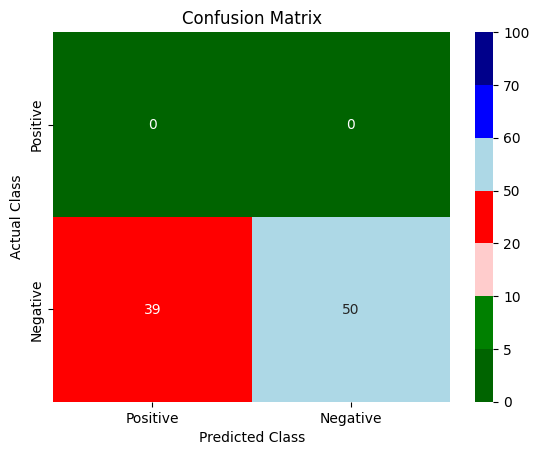

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define your color boundaries and corresponding colors
boundaries = [0, 5, 10, 20, 50, 60, 70, 100]  # Assuming 80 is your max value
colors = [
    'darkgreen',  # 0-5
    'green',      # 5-10
    '#ffcccc',    # 10-20 (light red)
    'red',        # 20-50
    'lightblue',  # 50-60
    'blue',       # 60-70
    'darkblue'    # above 70
]

# Create a colormap
custom_cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)


tp = sum(result['metric'] == 'true')  
fn = sum(result['metric'] == 'FN')    
tn = sum(result['metric'] == 'not true')  
fp = sum(result['metric'] == 'FP') 

conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# You can then plot this using seaborn or matplotlib
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_cmap, norm=norm, 
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()

__________________

## Saving the model

In [18]:
model_path = f"./models/{label}_lgbm.model"
joblib.dump(search_scr, model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at ./models/receipts_lgbm.model


## Feature importance

In [19]:
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import get_scorer_names


cv = KFold(n_splits=10, shuffle=True, random_state=42)

test_lofo = whole_docs.copy()
test_lofo[label] = y.copy()

dataset = Dataset(df=test_lofo, target=label, features=[col for col in test_lofo.columns if col != label])

full_pipeline = make_pipeline(
        SimpleImputer(), 
        MinMaxScaler(), 
        ExtraTreesClassifier()
    )

e:\Git&GitHub\Pictureminator\classifiers\Lib\site-packages\lofo\lofo_importance.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [20]:
%%time
lofo_imp = LOFOImportance(dataset, cv=cv, model=full_pipeline, scoring="accuracy")

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
%%time
importance_df = lofo_imp.get_importance()

100%|██████████| 57/57 [01:20<00:00,  1.42s/it]

CPU times: total: 1min 20s
Wall time: 1min 22s


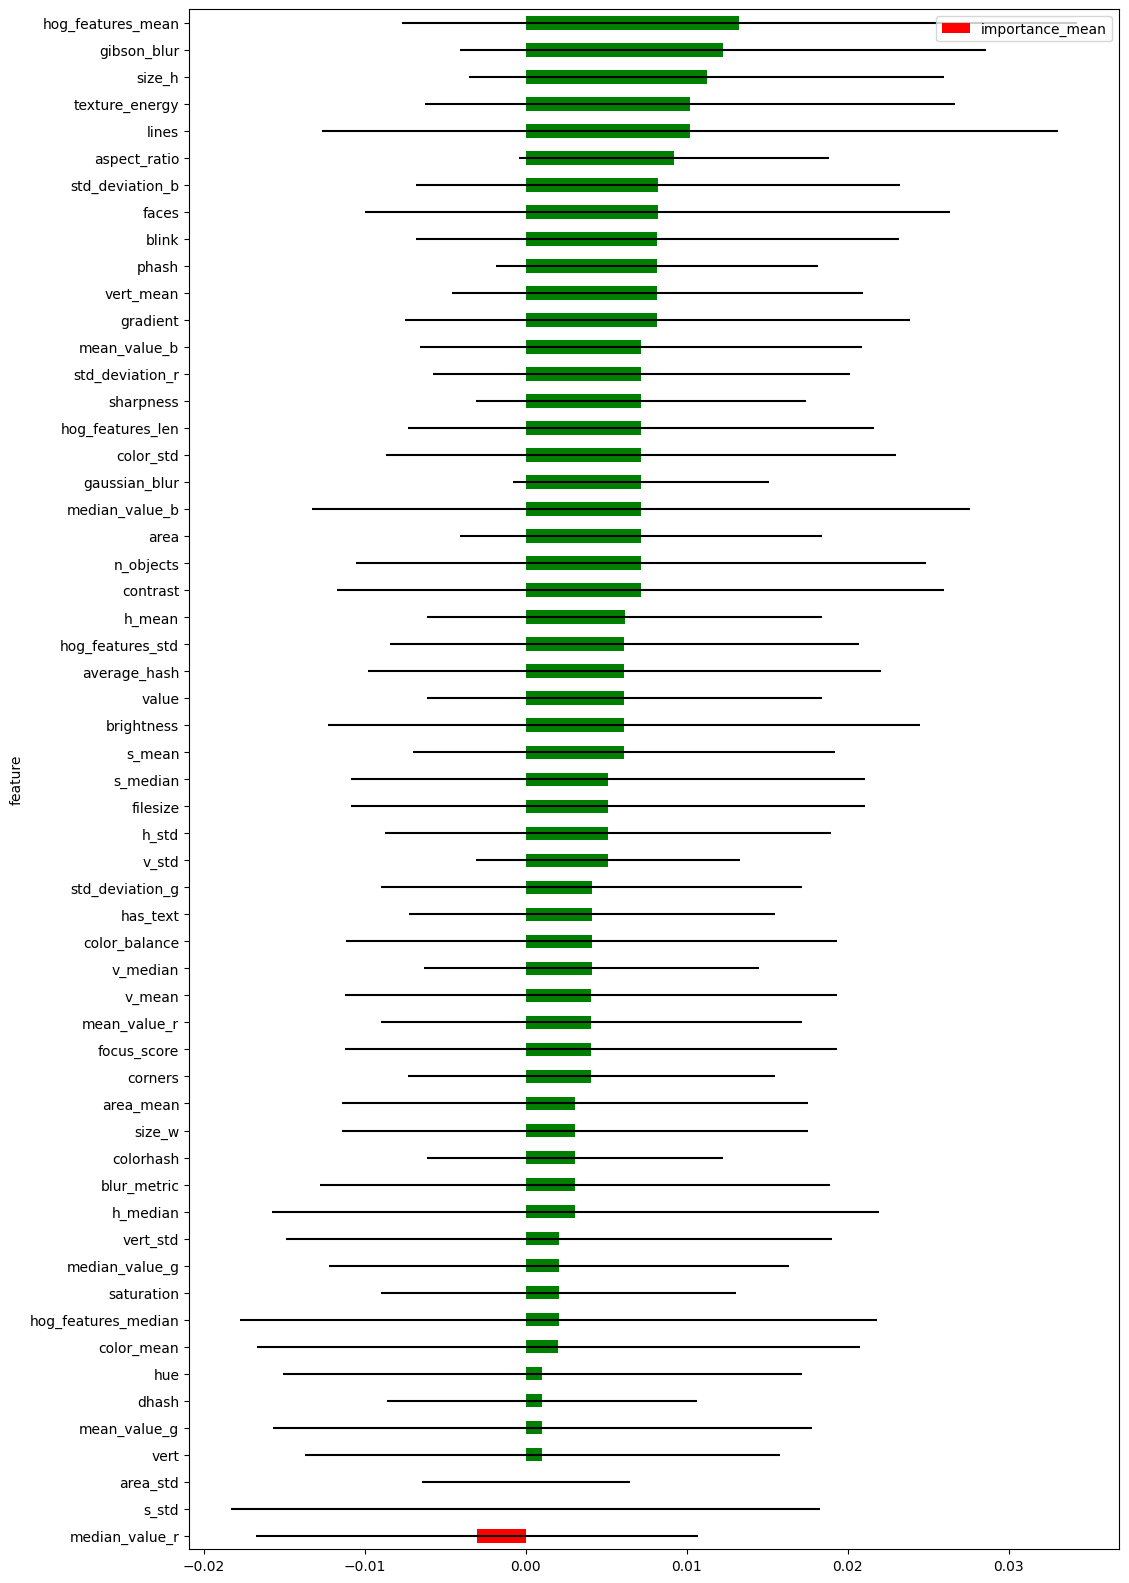

In [22]:
plot_importance(importance_df, figsize=(12, 20))


In [23]:
features_to_drop = importance_df.sort_values("importance_mean").head(7)["feature"]

In [24]:
whole_doc_less_features = whole_docs.drop(columns=features_to_drop)

## Verification run with lesser features - LGBM Classifier

In [25]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(whole_doc_less_features, y, test_size=0.15, random_state=42)

search_lgbm_l = c3.lgbm_model(X_train_l, y_train_l, param_lgbm)


Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[LightGBM] [Info] Number of positive: 259, number of negative: 573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11143
[LightGBM] [Info] Number of data points in the train set: 832, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.311298 -> initscore=-0.794058
[LightGBM] [Info] Start training from score -0.794058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [26]:
test_l = test.drop(columns=features_to_drop)


prediction_l = search_lgbm_l.predict(test_l)

result_l = pd.DataFrame()
result_l['filename'] = filenames
result_l['prediction'] = prediction

result_l.loc[(result_l.prediction == 1) & (result_l.filename.str.contains("docs")), "metric"] = "true"
result_l.loc[(result_l.prediction == 0) & (result_l.filename.str.contains("docs")), "metric"] = "FN"
result_l.loc[(result_l.prediction == 0) & (~result_l.filename.str.contains("docs")), "metric"] = "not true"
result_l.loc[(result_l.prediction == 1) & (~result_l.filename.str.contains("docs")), "metric"] = "FP"

result_l.groupby("metric").count()

,filename,prediction
metric,,
FN,7,7
FP,35,35
not true,43,43
true,4,4
